In [7]:
setwd("~/HRJ_monocytes/hILCs")
library(data.table)
library(dplyr)
library(stringr)
library(ggplot2)
library(tidyr)
library(pheatmap)

# 1. Compare COGs runs: Classic, classic+imputed, SuSIE+imputed
# Make a heatmap to show which genes were prioritised by which approaches

# 2. remake the heatmaps showing contributions of COGS scores to put in the supplementary fig

# 3. Show the difference that ABC gives. For this, just show the range of COGS scores for without and with ABC (violin plot) - or show paired changes?
# with PTPRK marked. And cutoff at 0.5 shown.

In [8]:
### Load the COGS results from each run. Indicate per gene if COGS >= 0.5 and combine them.

filter_COGS <- function(dt, COGSrun) {
    dt[, c("chr37", "chr38", "biotype", "minTss37", "maxTss37", "minTss38", "maxTss38") := NULL]
    dt[cogs >= 0.5, cogs_prioritised := 1]
    dt[cogs < 0.5, cogs_prioritised := 0]
    myname <- paste0(COGSrun, "_cogs")
    setnames(dt, "cogs_prioritised", myname)
    dt[, cogs := NULL]
}

classic <- fread("./COGS_results/COGS_out/CD_deLange_ILCs_hg38_ClassicCOGS_combinedInteractions_ALL/Annotated_COGS_scores_data.table.txt")
filter_COGS(classic, "classic")
impute <- fread("./COGS_results/COGS_out/CD_deLange_ILCs_hg38_ClassicCOGS_imputed_combinedInteractions_ALL/Annotated_COGS_scores_data.table.txt")
filter_COGS(impute, "classic+impute")
susie <- fread("./COGS_results/COGS_out/CD_deLange_ILCs_hg38_SuSIE_combinedInteractions_ALL/Annotated_COGS_scores_data.table.txt")
filter_COGS(susie, "SuSIE+impute")

bind1 <- merge.data.table(classic, impute, all = T)
all_res <- merge.data.table(bind1, susie, all = T)

# remove cases that are NA in all three cases.
sig_res <- all_res[classic_cogs == 1 | `classic+impute_cogs` == 1 | `SuSIE+impute_cogs` == 1]

# set remaining NA to 0
sig_res[is.na(sig_res)] <- 0

# if there's no gene name, put the ENSG ID. then, remove the ensg column.
# might need to look these up. Not sure if I did before.
sig_res[gene == "", gene := ensg]
sig_res[, ensg := NULL]

# set col order manually
setorder(sig_res, cols = -"SuSIE+impute_cogs", "classic+impute_cogs", "classic_cogs", "gene")


print(sig_res)

              gene classic_cogs classic+impute_cogs SuSIE+impute_cogs
  1:      ATP6V1G3            0                   0                 1
  2:          BATF            0                   0                 1
  3:          BDH2            0                   0                 1
  4:          CFL1            0                   0                 1
  5:         FOSL2            0                   0                 1
 ---                                                                 
 98:         USP49            1                   1                 1
 99:        ZBTB38            1                   1                 1
100:          JAK2            1                   0                 0
101:          CREM            1                   1                 0
102: RP11-894J14.5            1                   1                 0


png 
  2

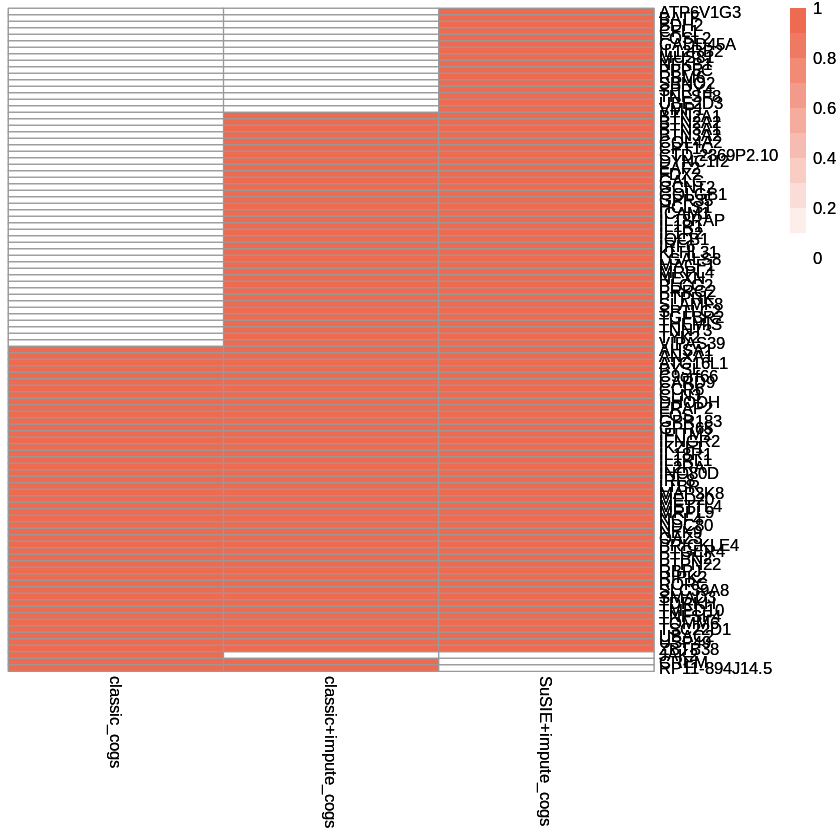

In [9]:
# Make the heatmap
mat <- as.data.frame(sig_res)
rownames(mat) <- mat[,1]
mat2 <- mat[ -c(1) ]

# draw the heatmap with row and column annotations

save_pheatmap_pdf <- function(x, filename, width=2.5, height=14) {
    stopifnot(!missing(x))
    stopifnot(!missing(filename))
    pdf(filename, width=width, height=height)
    grid::grid.newpage()
    grid::grid.draw(x$gtable)
    dev.off()
}

paletteLength <- 10
myColor <- colorRampPalette(c("white", "coral2"))(paletteLength)

p <- pheatmap(mat2, cluster_rows = F, cluster_cols = F, 
              color = myColor) 
save_pheatmap_pdf(p, "./COGS_results/comparisons/heatmap_classicVimputeVsusie.pdf")
p

In [12]:
### Make heatmap showing contributions from all COGS components
# the ones to use are from: susie. but need to keep the ensgid and the overall score

susie <- fread("./COGS_results/COGS_out/CD_deLange_ILCs_hg38_SuSIE_combinedInteractions_ALL/Annotated_COGS_scores_data.table.txt")
susie[, c("chr37", "chr38", "biotype", "minTss37", "maxTss37", "minTss38", "maxTss38") := NULL]
susie_sig <- susie[cogs >= 0.5]
#print(susie_sig)

# to load:
### 5kb interactions
### fragres interactions
### ABC 
### VProm
### Coding

filter_cogs_keepScores <- function(dt, COGSrun) {
    dt[, c("chr37", "chr38", "biotype", "minTss37", "maxTss37", "minTss38", "maxTss38") := NULL]
    myname <- paste0(COGSrun, "_cogs")
    setnames(dt, "cogs", myname)
}

CHiC <- fread("./COGS_results/COGS_out/CD_deLange_ILCs_hg38_SuSIE_combinedInteractions_allCHiC/Annotated_COGS_scores_data.table.txt")
filter_cogs_keepScores(CHiC, "CHiC")

abc <- fread("./COGS_results/COGS_out/CD_deLange_ILCs_hg38_SuSIE_combinedInteractions_ABCOnly/Annotated_COGS_scores_data.table.txt")
filter_cogs_keepScores(abc, "abc")

vprom <- fread("./COGS_results/COGS_out/CD_deLange_ILCs_hg38_SuSIE_combinedInteractions_VProm_only/Annotated_COGS_scores_data.table.txt")
filter_cogs_keepScores(vprom, "vprom")

coding <- fread("./COGS_results/COGS_out/CD_deLange_ILCs_hg38_SuSIE_combinedInteractions_coding_only/Annotated_COGS_scores_data.table.txt")
filter_cogs_keepScores(coding, "coding")

bind1 <- CHiC[susie_sig, on = c("ensg", "gene")] # keep only those that are significant in overall COGS (in susie_sig)
# now merge the rest in the same way
bind2 <- vprom[bind1, on = c("ensg", "gene")]
bind3 <- coding[bind2, on = c("ensg", "gene")]
allCogs <- abc[bind3, on = c("ensg", "gene")]

allCogs[, ensg := NULL]
print(allCogs)


             gene     abc_cogs  coding_cogs   vprom_cogs    CHiC_cogs      cogs
 1:       GADD45A 2.555912e-05 0.000000e+00 4.745396e-05 9.996657e-01 0.9996667
 2:          NCF4           NA 5.589490e-06 9.977553e-01           NA 0.9977609
 3:      ATP6V1G3           NA 5.379903e-08 9.948705e-07 9.976102e-01 0.9976113
 4:       DYNC1I2           NA           NA 1.396259e-03 9.958471e-01 0.9958529
 5:        SLAMF8           NA 9.939657e-01 2.540132e-05 5.261808e-06 0.9939951
 6:         IKZF1           NA 4.039407e-06 7.977287e-05 9.939638e-01 0.9939671
 7:         USP49           NA 2.040919e-06 2.791276e-05 9.915869e-01 0.9916168
 8:          LTBR 6.843293e-08 6.322104e-05 9.910947e-01           NA 0.9911579
 9:        MAP3K8 1.986436e-08 8.379229e-04 5.828803e-03 9.825441e-01 0.9892108
10:          BATF 8.055092e-05           NA 5.889175e-01 3.867503e-01 0.9756638
11:         GPR35 2.658454e-04 2.965821e-01 6.767091e-01           NA 0.9725988
12:         MACF1           NA 2.324048e

png 
  2

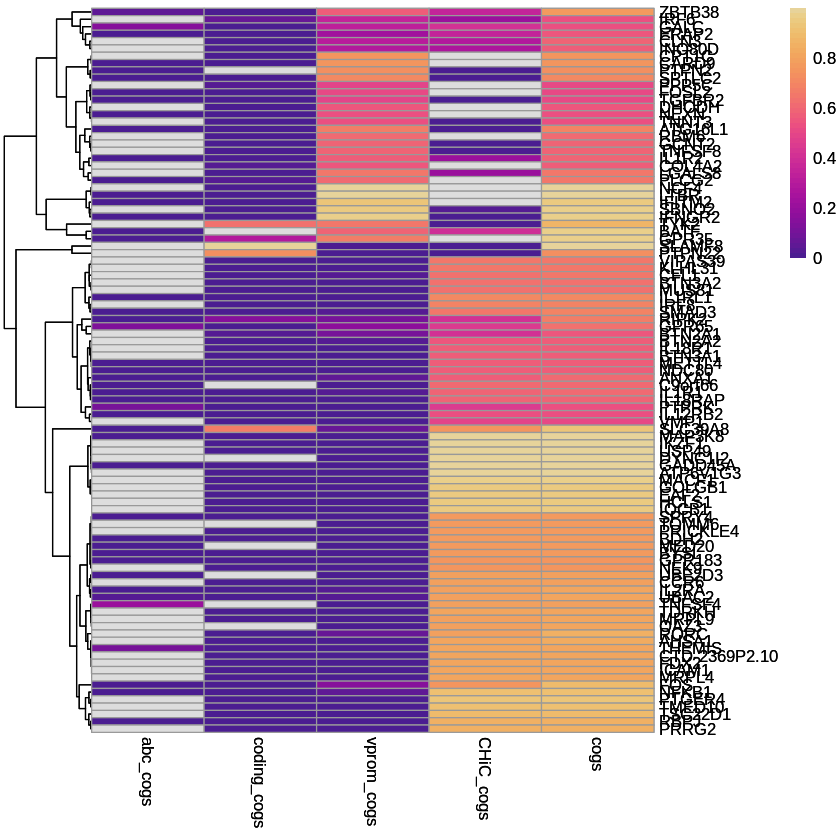

In [13]:
### Make the heatmap

mat <- as.data.frame(allCogs)
rownames(mat) <- mat[,1]
mat2 <- mat[ -c(1) ]

# draw the heatmap with row and column annotations
paletteLength <- 50
myColor1 <- colorRampPalette(grDevices::hcl.colors(50, palette = "ag_sunset"))
myColor <- myColor1(50)

save_pheatmap_pdf <- function(x, filename, width=3.5, height=14) {
    stopifnot(!missing(x))
    stopifnot(!missing(filename))
    pdf(filename, width=width, height=height)
    grid::grid.newpage()
    grid::grid.draw(x$gtable)
    dev.off()
}

p <- pheatmap(mat2, cluster_rows = T, cluster_cols = F, 
              color = myColor) 
save_pheatmap_pdf(p, "./COGS_results/comparisons/heatmap_COGScontributions.pdf")
p

png 
  2

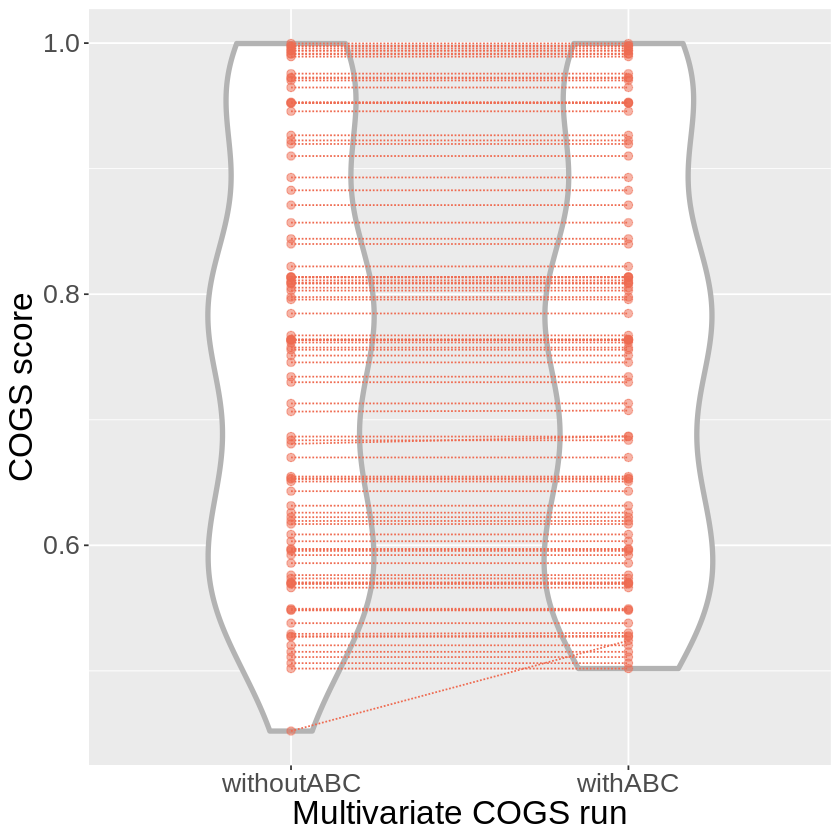

In [14]:
### Show changes from ABC.
#library(ggpubr)
#ggpaired()
### first see how a simple boxplot looks.
susie_noabc <- fread("./COGS_results/COGS_out/CD_deLange_ILCs_hg38_SuSIE_combinedInteractions_no_ABC/Annotated_COGS_scores_data.table.txt")
susie_noabc[, c("chr37", "chr38", "biotype", "minTss37", "maxTss37", "minTss38", "maxTss38") := NULL]
setnames(susie_noabc, "cogs", "withoutABC")
susie <- fread("./COGS_results/COGS_out/CD_deLange_ILCs_hg38_SuSIE_combinedInteractions_ALL/Annotated_COGS_scores_data.table.txt")
susie[, c("chr37", "chr38", "biotype", "minTss37", "maxTss37", "minTss38", "maxTss38") := NULL]
setnames(susie, "cogs", "withABC")

both <- merge.data.table(susie_noabc, susie, on  = c("ensg", "gene"), all = T)

# melt for ggplot
both_toplot <- melt.data.table(both, id.vars = c("ensg", "gene"), measure.vars = c("withoutABC", "withABC"), variable.name = "condition", value.name = "COGS_score")
both_toplot[, id := paste(ensg, gene, sep = "_")]
both_toplot[, c("ensg", "gene") := NULL]
#print(both_toplot)

library(ggplot2)
p <- ggplot(both_toplot, aes(x = condition, y = COGS_score)) + geom_violin()

# not good, so many at zero
# only show increases for genes significant in ABC

both_sigABC <- both[withABC >= 0.5]
# melt for ggplot
both_toplot2 <- melt.data.table(both_sigABC, id.vars = c("ensg", "gene"), measure.vars = c("withoutABC", "withABC"), variable.name = "condition", value.name = "COGS_score")
both_toplot2[, id := paste(ensg, gene, sep = "_")]
both_toplot2[, c("ensg", "gene") := NULL]

q <- ggplot(both_toplot2, aes(x = condition, y = COGS_score)) + 
  geom_violin(width=0.5, size=1.5, colour="grey70") + 
  geom_point(colour="coral2", size=2, alpha=0.5) +
  geom_line(aes(group=id), colour="coral2", linetype="11") +
  theme(text = element_text(size = 20)) +
  ylab("COGS score") +
  xlab("Multivariate COGS run")
print(q)

pdf(file = "./COGS_results/comparisons/violinplots_ABCvsnoABC_withLines.pdf", width = 8, height = 8)
print(q)
dev.off()


In [15]:
options(scipen = 999)

### Get bed files/interactions for ABC versus fiveKB in the PTPRK locus
susie <- fread("./COGS_results/COGS_out/CD_deLange_ILCs_hg38_SuSIE_combinedInteractions_ALL/Annotated_COGS_scores_data.table.txt")
#susie[gene == "PTPRK"]
myChrom <- 6
myStart <- 127500000
myEnd <-  129500000

ppis <- fread("./COGS_results/COGS_out/CD_deLange_ILCs_hg38_SuSIE_combinedInteractions_ALL/COGS_PPIs_data.table.txt")
ppis_PTPRK <- ppis[pos >= 127500000 & pos <= 129500000]
range(ppis_PTPRK$ppi)

ppis_bed1 <- ppis_PTPRK[, .(chr, pos, ppi)]
ppis_bed1[, pos0 := pos-1 ]
ppis_bed1[, chrom := paste0("chr", chr)]
ppis_bed <- ppis_bed1[, .(chrom, pos0, pos, ppi)]
print(ppis_bed)
fwrite(ppis_bed, file = "./browser_tracks/PTPRK_region_ppis.bedgraph", sep = "\t", quote  = F, 
       row.names = F, col.names = F)

[1] 0.000000000000006586093 0.425910858196077990456

       chrom      pos0       pos                     ppi
    1:  chr9 129499868 129499869 0.000032634423934726102
    2:  chr9 129499863 129499864 0.000011405603742432601
    3:  chr9 129499712 129499713 0.000019612238202653699
    4:  chr9 129499569 129499570 0.000032823143630754202
    5:  chr9 129498748 129498749 0.000013610215599001600
   ---                                                  
76492:  chr8 127501059 127501060 0.000000000000006586093
76493:  chr8 127500786 127500787 0.000000000000006586093
76494:  chr8 127500515 127500516 0.000000000000006586093
76495:  chr8 127500240 127500241 0.000000000000006586093
76496:  chr8 127500113 127500114 0.000000000000006586093


In [17]:
### Get the ABC interactions, fiveK interactions and DpnII interactions for the gene in question
ints <- fread("~/HRJ_monocytes/hILCs/rCOGS_in/COGS_input_deLange_ILCs_hg38_SuSIE_fix_combinedInteractions/ILC3_chicago_fres_5kb_abc_fres_consensus_peakm.txt_pm.format.txt")

# Change the coords for WashU 
ints[baitStart < oeStart, `:=` (leftChr = paste0("chr", baitChr), 
                                 leftStart = baitStart, 
                                 leftEnd = baitEnd, 
                                 rightChr = paste0("chr", oeChr),
                                 rightStart = oeStart,
                                 rightEnd = oeEnd)]
ints[baitStart > oeStart, `:=` (leftChr = paste0("chr", oeChr), 
                                 leftStart = oeStart, 
                                 leftEnd = oeEnd, 
                                 rightChr = paste0("chr", baitChr),
                                 rightStart = baitStart,
                                 rightEnd = baitEnd)]

ints[, washURight_temp := paste(rightChr, rightStart, sep = ":")]
ints[, washURight_temp2 := paste(washURight_temp, rightEnd, sep = "-")]


PTPRK <- ints[name == "PTPRK"]

# For ABC:
abc <- PTPRK[!is.na(`ABC.Score`)]
abc[, washURight := paste(washURight_temp2, `ABC.Score`, sep = ",")]
abc_washU <- abc[, .(leftChr, leftStart, leftEnd, washURight)]
print(abc_washU)
fwrite(abc_washU, file = "./browser_tracks/PTPRK_region_ABC_PTPRK_ints_WashU.txt", sep = "\t", quote = F, row.names = F, col.names = F)

# For ABC:
abc <- PTPRK[!is.na(`ABC.Score`)]
abc[, washURight := paste(washURight_temp2, `ABC.Score`, sep = ",")]
abc_washU <- abc[, .(leftChr, leftStart, leftEnd, washURight)]
print(abc_washU)
fwrite(abc_washU, file = "./browser_tracks/PTPRK_region_ABC_PTPRK_ints_WashU.txt", sep = "\t", quote = F, row.names = F, col.names = F)

## The resolution here: I think the baits and OE are at fragment resolution
# For fragres:
fres <- PTPRK[!is.na(chicago_fres)]
fres[, washURight := paste(washURight_temp2, chicago_fres, sep = ",")]
fres_washU <- fres[, .(leftChr, leftStart, leftEnd, washURight)]
print(fres_washU)
fwrite(fres_washU, file = "./browser_tracks/PTPRK_region_fres_PTPRK_ints_WashU.txt", sep = "\t", quote = F, row.names = F, col.names = F)

# For fiveK:
fiveK <- PTPRK[!is.na(chicago_5kb)]
fiveK[, washURight := paste(washURight_temp2, chicago_5kb, sep = ",")]
fiveK_washU <- fres[, .(leftChr, leftStart, leftEnd, washURight)]
print(fiveK_washU)
fwrite(fiveK_washU, file = "./browser_tracks/PTPRK_region_fiveK_PTPRK_ints_WashU.txt", sep = "\t", quote = F, row.names = F, col.names = F)

   leftChr leftStart   leftEnd                   washURight
1:    chr6 127971074 127971792 chr6:128520408-128521142,5.1
2:    chr6 127971793 127971907 chr6:128520408-128521142,5.1
3:    chr6 127971908 127972221 chr6:128520408-128521142,5.1
4:    chr6 127972222 127972316 chr6:128520408-128521142,5.1
5:    chr6 127972317 127972584 chr6:128520408-128521142,5.1
6:    chr6 127972585 127973332 chr6:128520408-128521142,5.1
7:    chr6 128520408 128521142 chr6:129490111-129491103,5.1
8:    chr6 128520408 128521142 chr6:129491104-129491253,5.1
9:    chr6 128520408 128521142 chr6:129491254-129491735,5.1
   leftChr leftStart   leftEnd                   washURight
1:    chr6 127971074 127971792 chr6:128520408-128521142,5.1
2:    chr6 127971793 127971907 chr6:128520408-128521142,5.1
3:    chr6 127971908 127972221 chr6:128520408-128521142,5.1
4:    chr6 127972222 127972316 chr6:128520408-128521142,5.1
5:    chr6 127972317 127972584 chr6:128520408-128521142,5.1
6:    chr6 127972585 127973332 chr6:1285

In [18]:
### Now get the PPIs for JAK2 region in univariate and multivariate COGS
# I already have classic and SuSIE. Just get the one for classic + imputation

ppis <- fread("./COGS_results/COGS_out/CD_deLange_ILCs_hg38_ClassicCOGS_imputed_combinedInteractions_ALL/COGS_PPIs_data.table.txt")

myChrom <- 9
myStart <- 4748365
myEnd <-  5214860

ppis_JAK2 <- ppis[pos >= myStart & pos <= myEnd]
range(ppis_JAK2$ppi)

ppis_bed1 <- ppis_JAK2[, .(chr, pos, ppi)]
ppis_bed1[, pos0 := pos-1 ]
ppis_bed1[, chrom := paste0("chr", chr)]
ppis_bed <- ppis_bed1[, .(chrom, pos0, pos, ppi)]
ppis_bed_keep <- ppis_bed[ppi > 0.0001]
print(ppis_bed_keep)

fwrite(ppis_bed_keep, file = "./browser_tracks/JAK2_region_classicImpute_ppis.bedgraph", sep = "\t", quote  = F, 
      row.names = F, col.names = F)

[1] 0.00000000000000001420877 0.39728241052231699770303

      chrom    pos0     pos          ppi
   1:  chr9 5149656 5149657 0.0001410715
   2:  chr9 5146951 5146952 0.0001188716
   3:  chr9 5140670 5140671 0.0001240646
   4:  chr9 5131730 5131731 0.0001294886
   5:  chr9 5115212 5115213 0.0001045803
  ---                                   
4757: chr10 4764222 4764223 0.0001230555
4758: chr10 4763324 4763325 0.0001012395
4759: chr10 4762107 4762108 0.0001060482
4760: chr10 4762024 4762025 0.0001061134
4761: chr10 4760348 4760349 0.0008202228


In [19]:
# check - in imputation or SuSIE, were any other genes identified in this locus?
impute <- fread("./COGS_results/COGS_out/CD_deLange_ILCs_hg38_ClassicCOGS_imputed_combinedInteractions_ALL/Annotated_COGS_scores_data.table.txt")
#print(impute)

myChrom <- 9
myStart <- 4700000
myEnd <-  5300000

JAK2_impute <- impute[chr38 == myChrom & minTss38 >= myStart & maxTss38 <= myEnd]
print(JAK2_impute)
# RCL1 got some signal

susie <- fread("./COGS_results/COGS_out/CD_deLange_ILCs_hg38_SuSIE_combinedInteractions_ALL/Annotated_COGS_scores_data.table.txt")
#print(susie)

JAK2_susie <- susie[chr38 == myChrom & minTss38 >= myStart & maxTss38 <= myEnd]
print(JAK2_susie)
# RCL1 went down and so did JAK2
# There are no other genes in the vicinity that go up




              ensg chr37 chr38  gene        biotype minTss37 maxTss37 minTss38
1: ENSG00000096968     9     9  JAK2 protein_coding  4985033  5125965  4984390
2: ENSG00000120158     9     9  RCL1 protein_coding  4792869  4860454  4792869
3: ENSG00000147853     9     9   AK3 protein_coding  4741227  4742043  4741227
4: ENSG00000120210     9     9 INSL6 protein_coding  5164251  5185668  5164251
5: ENSG00000120211     9     9 INSL4 protein_coding  5231419  5231419  5231419
   maxTss38           cogs
1:  5125965 0.410952363331
2:  4860454 0.134004367016
3:  4742043 0.000796845723
4:  5185668 0.000183775134
5:  5231419 0.000007534309
              ensg chr37 chr38  gene        biotype minTss37 maxTss37 minTss38
1: ENSG00000120158     9     9  RCL1 protein_coding  4792869  4860454  4792869
2: ENSG00000096968     9     9  JAK2 protein_coding  4985033  5125965  4984390
3: ENSG00000120210     9     9 INSL6 protein_coding  5164251  5185668  5164251
4: ENSG00000147853     9     9   AK3 protein_cod

In [20]:
print(PTPRK[!is.na(chicago_fres)])

              ensg  name        biotype strand baitChr baitStart   baitEnd
1: ENSG00000152894 PTPRK protein_coding     -1       6 128064548 128064873
2: ENSG00000152894 PTPRK protein_coding     -1       6 128064548 128064873
3: ENSG00000152894 PTPRK protein_coding     -1       6 128320755 128322280
4: ENSG00000152894 PTPRK protein_coding     -1       6 128320755 128322280
5: ENSG00000152894 PTPRK protein_coding     -1       6 128320755 128322280
6: ENSG00000152894 PTPRK protein_coding     -1       6 128320755 128322280
    baitID baitName oeChr   oeStart     oeEnd    oeID oeName baitID_5kb
1: 5607347    PTPRK     6 128068865 128069086 5607357                NA
2: 5607347    PTPRK     6 128072915 128073165 5607364            454564
3: 5607898    PTPRK     6 128318293 128318794 5607894                NA
4: 5607898    PTPRK     6 128322949 128323755 5607902                NA
5: 5607898    PTPRK     6 128324508 128325154 5607906                NA
6: 5607898    PTPRK     6 128327429 1283281